In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy.stats import chi2
from astropy.io import fits
from heapq import nsmallest


import hendrics.io as HENio
import stingray
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray.powerspectrum import AveragedPowerspectrum
from stingray.gti import create_gti_from_condition, cross_gtis, cross_two_gtis, gti_len
from stingray.deadtime.fad import calculate_FAD_correction # this is how we handle deadtime
from stingray.stats import z2_n_detection_level, z2_n_probability
from stingray.pulse.search import plot_profile, epoch_folding_search, z_n_search
from stingray.simulator.simulator import Simulator
from stingray.pulse.search import search_best_peaks

from stingray.pulse.modeling import fit_sinc, fit_gaussian

from astropy.modeling import models # for the models we will use to fit our data
from astropy.timeseries import LombScargle
from stingray.modeling import PSDLogLikelihood, PSDParEst, set_logprior, PSDPosterior # for fitting methods + stats
from stingray.modeling import GaussianLogLikelihood, GaussianPosterior, ParameterEstimation # more fitting + stats

from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import epoch_folding_search, z_n_search

/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/utils.py:24: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")
/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not instal

In [2]:
def printGTIs(lc,ev):
    #get duration of observations, good exposure time, and total events
    obs_duration = lc.gti[-1][-1] - lc.gti[0][0]
    totalGTI = gti_len(lc.gti)
    arrival_times = ev.time

    print('Total Duration of Observations: {} seconds'.format(obs_duration))
    print('Total "Good" Exposure Time: {} seconds'.format(totalGTI))
    print('Total Events: {}'.format(len(arrival_times)))

In [3]:
mos1EV = HENio.load_events('mos1_filt_time_xmm_emos1_det01_ev_calib.nc')
mos2EV = HENio.load_events('mos2_filt_time_xmm_emos2_det01_ev_calib.nc')
pnEV = HENio.load_events('pn_filt_time_xmm_epn_det04_ev_calib.nc')

In [4]:
evList = [mos1EV,mos2EV,pnEV]
total = 0
for ev in evList:
    duration = ev.time[-1] - ev.time[0]
    total += duration
print(total)

50933.026265501976


In [5]:
ev = mos1EV.join(mos2EV)
srcEV = ev.join(pnEV)

In [6]:
#Creating a background mask
times = srcEV.time
energy = srcEV.energy
#range of energy that the mask applies to
e_min = .2
e_max = 12

#mask is a boolean array that is false outside the energy range
mask =  (energy >= e_min) & (energy <= e_max)

bkgrnd_times = times[mask]
bkgrnd_energy = energy[mask]

#background event list is creating from the mask
bkgrnd_ev = EventList(time=bkgrnd_times,energy=bkgrnd_energy)

In [7]:
bkgrnd_lc = bkgrnd_ev.to_lc(dt=1)
source_lc = srcEV.to_lc(dt=1)
source_lc.apply_gtis()
correctedgtis = cross_two_gtis(source_lc.gti,bkgrnd_lc.gti)

In [8]:
#get duration of observations, good exposure time, and total events
obs_duration = source_lc.gti[-1][-1] - source_lc.gti[0][0]
totalGTI = gti_len(source_lc.gti)
arrival_times = srcEV.time

print('Total Duration of Observations: {} seconds'.format(obs_duration))
print('Total "Good" Exposure Time: {} seconds'.format(totalGTI))
print('Total Events: {}'.format(len(arrival_times)))

Total Duration of Observations: 15760.85490655899 seconds
Total "Good" Exposure Time: 15187.120779275894 seconds
Total Events: 17586


In [9]:
#to replicate Oliveira's paper, lightcurves are made from the .3-2,
#2-10, and .3-10 energy bands

e_minS = .3
e_maxS = 2
maskS =  (energy >= e_minS) & (energy <= e_maxS)
soft_energy = energy[maskS]
soft_times = times[maskS]
softEV = EventList(time=soft_times, energy=soft_energy)
softLC = softEV.to_lc(dt=10)

e_minH = 2
e_maxH = 10
maskH =  (energy >= e_minH) & (energy <= e_maxH)
hard_energy = energy[maskH]
hard_times = times[maskH]
hardEV = EventList(time=hard_times, energy=hard_energy)
hardLC = hardEV.to_lc(dt=10)

e_minF = .3
e_maxF = 10
maskF =  (energy >= e_minF) & (energy <= e_maxF)
full_energy = energy[maskF]
full_times = times[maskF]
fullEV = EventList(time=full_times, energy=full_energy)
fullLC = fullEV.to_lc(dt=10)

In [10]:
printGTIs(softLC,softEV)

Total Duration of Observations: 17600.0 seconds
Total "Good" Exposure Time: 17600.0 seconds
Total Events: 12140


In [11]:
printGTIs(hardLC,hardEV)

Total Duration of Observations: 17580.0 seconds
Total "Good" Exposure Time: 17580.0 seconds
Total Events: 4532


In [12]:
printGTIs(fullLC,fullEV)

Total Duration of Observations: 17600.0 seconds
Total "Good" Exposure Time: 17600.0 seconds
Total Events: 16672


In [13]:
src_rebin = source_lc.rebin(dt_new = 20)
bkgrnd_rebin = bkgrnd_lc.rebin(dt_new = 20)

In [14]:
src_split = src_rebin.split_by_gti()
bkgrnd_split = bkgrnd_rebin.split_by_gti()

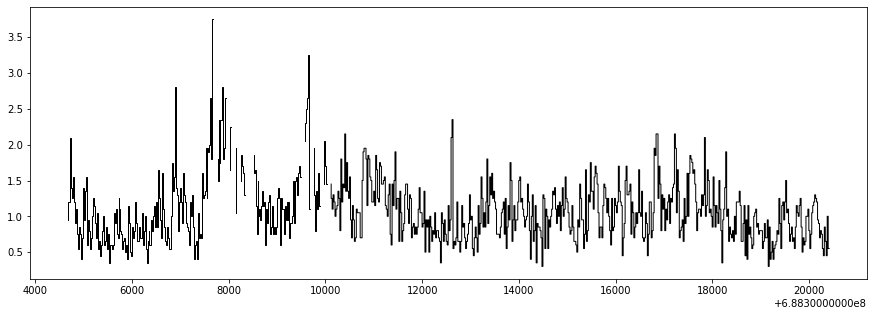

In [15]:
# rebin the lightcurve to make it easier to read
# break the lightcurve up by gti's (makes plotting prettier)


fig, ax = plt.subplots(figsize = (15, 5))

for lightcurve in src_split:
    ax.plot(lightcurve.time, lightcurve.countrate, lw = 1, color = 'black', ds = 'steps')


    

In [16]:
correctedgtis = create_gti_from_condition(bkgrnd_lc.time, bkgrnd_lc.countrate <= 1)
correctedgtis = cross_two_gtis(srcEV.gti,correctedgtis)
lc =  srcEV.to_lc(dt=.5)
lc.gti = correctedgtis
lc.apply_gtis()
lc_rebin = lc.rebin(dt_new = 1.5)
lc_split = lc_rebin.split_by_gti()

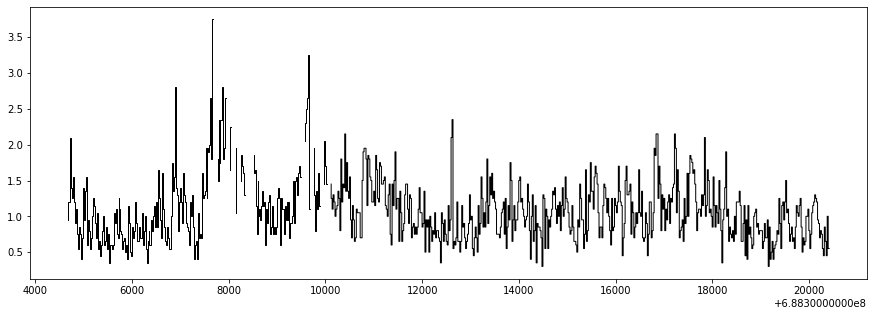

In [17]:
fig, ax = plt.subplots(figsize = (15, 5))

for lightcurve in src_split:
    ax.plot(lightcurve.time, lightcurve.countrate, lw = 1, color = 'black', ds = 'steps')
    

# Power Density Spectrum

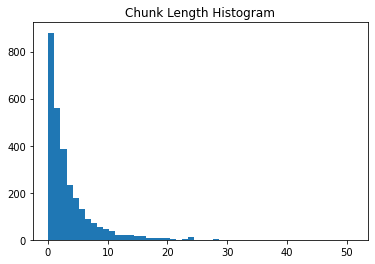

In [18]:
intervals = np.zeros(len(correctedgtis))

for i, gti in enumerate(correctedgtis):
    intervals[i] = gti[1] - gti[0]
plt.title("Chunk Length Histogram")
#histogram of chunk lengths
_ = plt.hist(intervals, 50)

In [19]:
print(intervals)

[ 8.4167732   1.          1.         ... 15.          2.
  0.43813336]


In [20]:
srcLCs = source_lc.split_by_gti()

In [21]:
srcLCs[-1].time[-1] -srcLCs[-1].time[0]

10321.0

In [22]:
pds = stingray.Powerspectrum(srcLCs[-1], norm = 'frac')

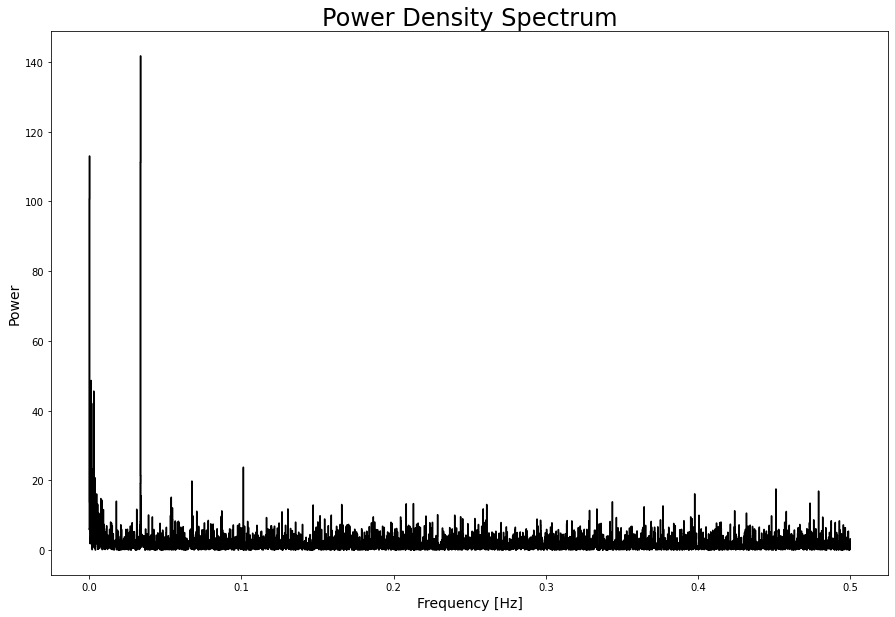

In [23]:
# create a PDS from your data
fig, ax = plt.subplots(figsize = (15, 10))

# plot PDS
ax.set_xlabel("Frequency [Hz]", size = 14)
ax.set_ylabel("Power", size = 14)
plt.title("Power Density Spectrum", size = 24)

plt.plot(pds.freq, pds.power, ds = "steps-mid", color = "black")

In [24]:
sim = Simulator(dt=1,N=10323, mean = np.mean(srcLCs[-1].countrate),rms=1)

In [25]:
#spin is 29.6 sec, orb is 1.76 hrs
spin_freq = 1/29.6
orb_freq = 1/6336
sig5 = 1 - .9999994 # Probability for 5-sigma detection
frequencies = np.arange(20e-3, 100e-3, 1e-6)

# Z^2 Test

In [28]:
frequency_z, zstat = z_n_search(srcEV.time, frequencies, nbin = 75, nharm = 2)

In [29]:
z_detlev = z2_n_detection_level(n = 2, epsilon = sig5, ntrial = len(frequencies))

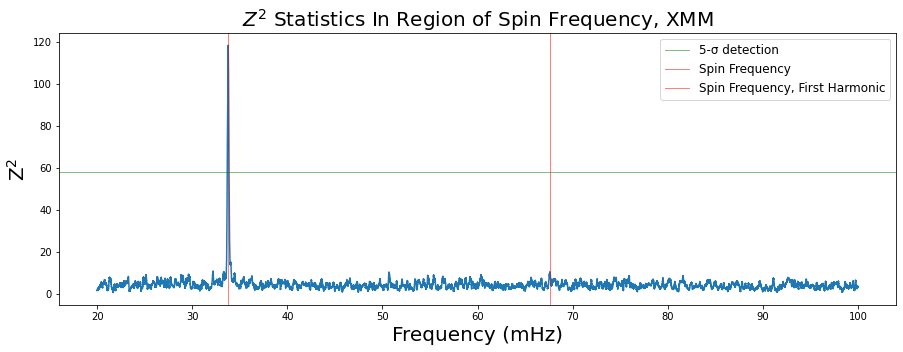

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(1000*frequency_z, zstat)
plt.axhline(z_detlev, lw=1, alpha=0.5, color='green', label='5-\u03c3 detection')
plt.axvline(spin_freq*1000, lw =1, alpha = .5,color='r', label='Spin Frequency')
plt.axvline(spin_freq*2000, lw =1, alpha = .5,color='r', label='Spin Frequency, First Harmonic')



plt.title(r'$Z^2$ Statistics In Region of Spin Frequency, XMM', fontsize='20')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Frequency (mHz)', fontsize=20)
_=plt.ylabel('Z$^2$', fontsize=20)

## High Resolution Z^2

In [31]:
hi_frequencies = np.arange(32e-3,35e-3, 5e-8)

In [32]:
hi_frequency_z, hi_zstat = z_n_search(srcEV.time, hi_frequencies, nbin = 75, nharm = 2)

In [33]:
hi_z_detlev = z2_n_detection_level(n = 2, epsilon = sig5, ntrial = len(hi_frequencies))

Text(0, 0.5, 'Z$^2$')

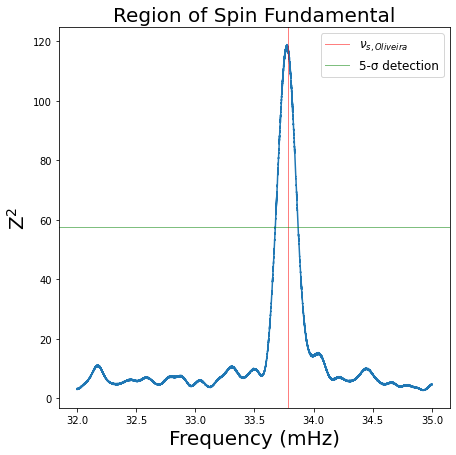

In [34]:
plt.figure(figsize=(7, 7))
plt.plot(1000*hi_frequency_z, hi_zstat)
plt.axvline(1000*spin_freq, lw=1, alpha=0.5, color='r', label=r'$\nu_{s,Oliveira}$')
plt.axhline(hi_z_detlev, lw=1, alpha=0.5, color='green', label='5-\u03c3 detection')

plt.title('Region of Spin Fundamental', fontsize='20')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Frequency (mHz)', fontsize=20)
plt.ylabel('Z$^2$', fontsize=20)

In [35]:
my_spin=hi_frequency_z[np.argmax(hi_zstat)]
oliveira_spin = spin_freq
spin_diff = oliveira_spin-my_spin

In [36]:
oliveira_spin = spin_freq

In [37]:
spin_diff = oliveira_spin-my_spin

In [38]:
spin_diff

9.23378373274969e-06

# Epoch Folding

In [43]:
ef_frequencies = np.arange(1e-4, 40e-3, 1e-6)

In [44]:
1/(1.76*3600)

0.00015782828282828284

In [45]:
ef_frequencies, efstat = epoch_folding_search(srcEV.time, ef_frequencies)

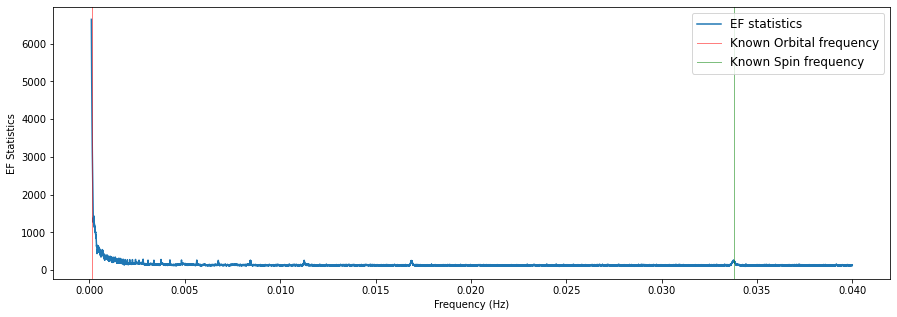

In [46]:
# ---- PLOTTING --------
plt.figure(figsize=(15, 5))
plt.plot(ef_frequencies, efstat, label='EF statistics')
plt.axvline(orb_freq, lw=1, alpha=0.5, color='r', label='Known Orbital frequency')
plt.axvline(spin_freq, lw=1, alpha=0.5, color='g', label='Known Spin frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')

plt.legend(loc='upper right', fontsize='large')


In [47]:
efAtSpin = fold_events(fullEV.time, spin_freq)
#folds = _z_sqr_phases(fullEV.time,spin_freq)

In [48]:
efAtSpin

(array([0.03125, 0.09375, 0.15625, 0.21875, 0.28125, 0.34375, 0.40625,
        0.46875, 0.53125, 0.59375, 0.65625, 0.71875, 0.78125, 0.84375,
        0.90625, 0.96875]),
 array([ 824.,  849.,  797.,  915., 1007., 1029., 1054., 1095., 1157.,
        1284., 1337., 1272., 1178., 1015.,  943.,  916.]),
 array([28.70540019, 29.13760457, 28.23118843, 30.24896692, 31.73326331,
        32.07802986, 32.46536616, 33.09078422, 34.0147027 , 35.83294573,
        36.5650106 , 35.665109  , 34.3220046 , 31.85906464, 30.70830507,
        30.2654919 ]))

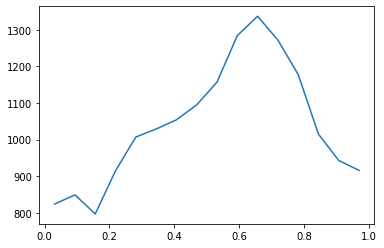

In [49]:
plt.plot(efAtSpin[0],efAtSpin[1])

# Lomb-Scargle Periodogram

In [50]:
sig1 = 1 - .6827 # Probability for 1-sigma detection
sig2 = 1 - .9545 # Probability for 2-sigma detection
sig3 = 1 - .9973 # Probability for 3-sigma detection
sig4 = 1 - .999937 # Probability for 4-sigma detection
sig5 = 1 - .9999994 # Probability for 5-sigma detection

prob_tholds = [sig1, sig2, sig3, sig4, sig5] # Probability thresholds to calculate FAP levels

#print('The Baluev thresholds are:', level_tholds)

In [51]:
def graphLombScargle(lc,start,end):
    # Plot the L-S Periodogram
    # Based on Time-Domain analysis, we can assume pre-centered data for the beat and spin frequencies
    
    # Plot the L-S Periodogram
    # Based on Time-Domain analysis, we can assume pre-centered data for the beat and spin frequencies
    frequency_ls= np.arange(1e-5,50e-3, 1e-7)
    ls = LombScargle(src_lc.time, src_lc.counts, dy=src_lc.counts_err, center_data=True, fit_mean=True)
    level_tholds = ls.false_alarm_level(prob_tholds, method='baluev')
    power_ls = ls.power(frequency_ls)
    # Look for prominent peaks

    top_10 = sorted(range(len(power_ls)), key=lambda i: power_ls[i])[-10:] # List of the indices of the top 10 power values

    top_10.reverse()

    # Cutoff values close to 0, since the strongest peak will be at 0

    top = []

    thold = 10e-5
    for i in top_10:
        if frequency_ls[i] >= 10e-5: top.append(i)
        
    plt.figure(figsize=(15, 5))
    plt.plot(1000*frequency_ls, power_ls)

    plt.title('Source Events Periodogram', fontsize='20')
    plt.xlabel('Frequency (mHz)')
    plt.axvline(1000*spin_freq,color='r', alpha=.2,label='Spin Frequency')
    plt.axvline(1000*orb_freq, color='green',alpha=.4,label='Orbital Frequency')
    plt.axvline(2000*orb_freq, color='green',alpha=.4,label='Orbital Harmonic')
    for i in range(len(level_tholds)):
        plt.axhline(level_tholds[i], lw=1, alpha=1, color=(1 - i*.1, 1 - i*.1, 1 - i*.1), label=str(i+1)+'-\u03c3')
    plt.xlim(start,end)
    plt.legend(loc='upper right', fontsize='large')
    _=plt.ylabel('L-S Power')
    #plt.ylim(-1e-5, 0.002)
    print("Most Significiant Period")
    print(1/frequency_ls[np.argmax(power_ls)])
    print(1/frequency_ls[np.argmax(power_ls)])
    
            
    for i,j in enumerate(top):
        print(i + 1, ':', power_ls[j], 'at', frequency_ls[j], 'Hz')

In [52]:
#creating a copy of source lc so I don't accidentally mess up any of
#my earlier work
src_lc = fullLC


In [53]:
# Plot the L-S Periodogram
# Based on Time-Domain analysis, we can assume pre-centered data for the beat and spin frequencies
frequency_ls= np.arange(1e-4,50e-3, 1e-7)
ls = LombScargle(src_lc.time, src_lc.counts, dy=src_lc.counts_err, center_data=True, fit_mean=True)
level_tholds = ls.false_alarm_level(prob_tholds, method='baluev')

power_ls = ls.power(frequency_ls)

In [54]:
# Look for prominent peaks

top_10 = sorted(range(len(power_ls)), key=lambda i: power_ls[i])[-10:] # List of the indices of the top 10 power values

top_10.reverse()

# Cutoff values close to 0, since the strongest peak will be at 0

top = []

thold = 30e-3
for i in top_10:
    if frequency_ls[i] >= thold: top.append(i)


In [56]:
        
for i,j in enumerate(top):
    print(i + 1, ':', power_ls[j], 'at', frequency_ls[j], 'Hz')

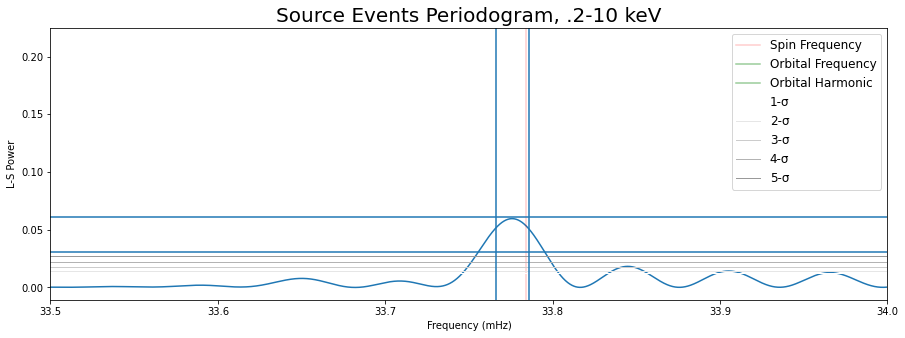

In [57]:
plt.figure(figsize=(15, 5))
plt.plot(1000*frequency_ls[:-15000], power_ls[:-15000])

plt.title('Source Events Periodogram, .2-10 keV', fontsize='20')
plt.xlabel('Frequency (mHz)')
plt.axvline(1000*spin_freq,color='r', alpha=.2,label='Spin Frequency')
plt.axvline(1000*orb_freq, color='green',alpha=.4,label='Orbital Frequency')
plt.axvline(2000*orb_freq, color='green',alpha=.4,label='Orbital Harmonic')

for i in range(len(level_tholds)):
    plt.axhline(level_tholds[i], lw=1, alpha=1, color=(1 - i*.1, 1 - i*.1, 1 - i*.1), label=str(i+1)+'-\u03c3')

plt.legend(loc='upper right', fontsize='large')
_=plt.ylabel('L-S Power')
plt.xlim(33.5, 34)
plt.axhline(.061)
plt.axhline(.0305)
plt.axvline(33.756+.00987499999999919)
plt.axvline(33.7955-.00987499999999919)

In [58]:
33.756+.00987499999999919

33.765875

In [59]:
33.7955-.00987499999999919

33.785624999999996

In [60]:
(33.785624999999996-33.765875)/2

0.009874999999997414

In [61]:
(spin_freq+((33.785624999999996-33.765875)/2000))-spin_freq

9.874999999999468e-06

In [62]:
1/frequency_ls[np.argmax(power_ls)]

8474.576271186408

Most Significiant Period
99999.99999999999
99999.99999999999


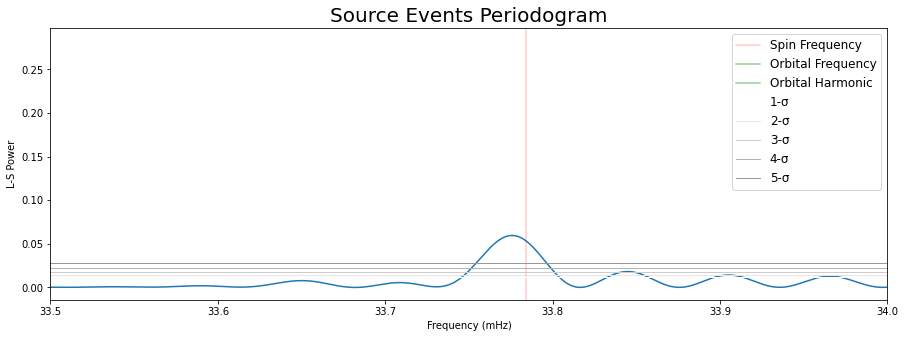

In [63]:
graphLombScargle(fullLC,33.5,34)

Most Significiant Period
99999.99999999999
99999.99999999999


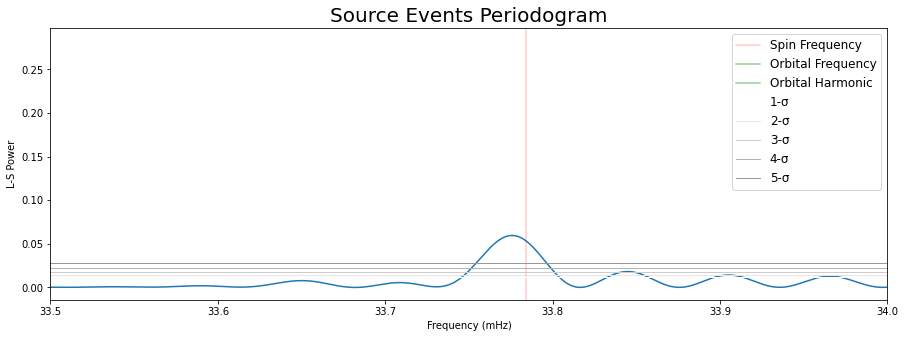

In [64]:
graphLombScargle(hardLC,33.5,34)

Most Significiant Period
99999.99999999999
99999.99999999999


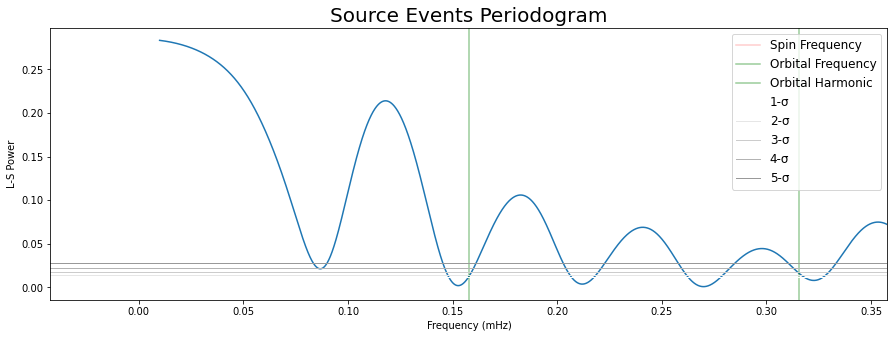

In [65]:
graphLombScargle(softLC,(orb_freq*1000)-.2,(orb_freq*1000)+.2)

Most Significiant Period
99999.99999999999
99999.99999999999


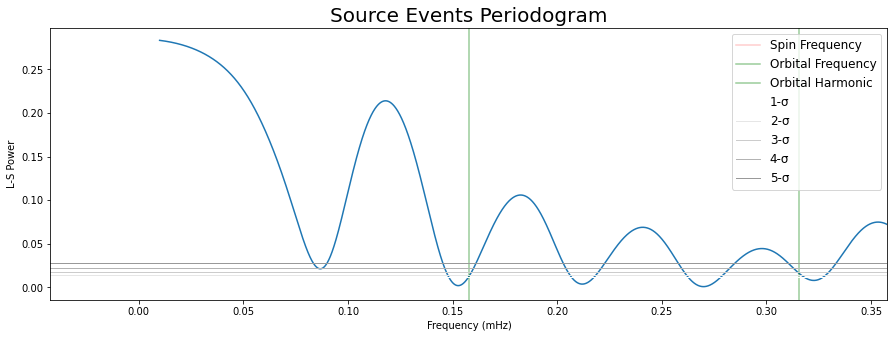

In [66]:
graphLombScargle(hardLC,(orb_freq*1000)-.2,(orb_freq*1000)+.2)

# Z^2 Test for .3-10 band

In [67]:
full_frequency_z, full_zstat = z_n_search(fullEV.time, frequencies, nbin = 75, nharm = 2)
full_z_detlev = z2_n_detection_level(n = 2, epsilon = sig5, ntrial = len(frequencies))

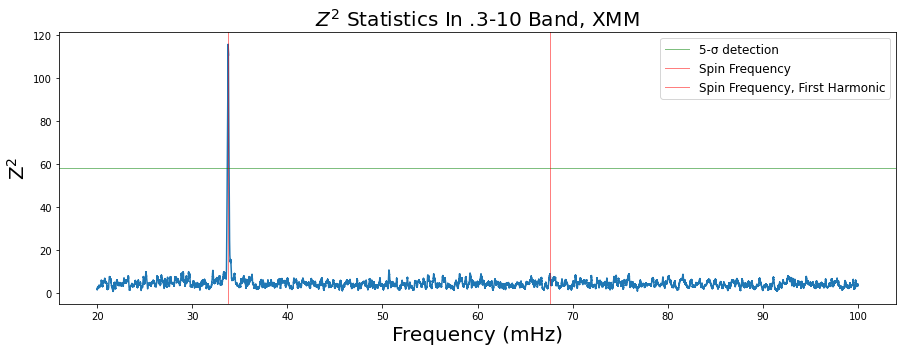

In [68]:
plt.figure(figsize=(15, 5))
plt.plot(1000*full_frequency_z, full_zstat)
plt.axhline(full_z_detlev, lw=1, alpha=0.5, color='green', label='5-\u03c3 detection')
plt.axvline(spin_freq*1000, lw =1, alpha = .5,color='r', label='Spin Frequency')
plt.axvline(spin_freq*2000, lw =1, alpha = .5,color='r', label='Spin Frequency, First Harmonic')



plt.title(r'$Z^2$ Statistics In .3-10 Band, XMM', fontsize='20')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Frequency (mHz)', fontsize=20)
_=plt.ylabel('Z$^2$', fontsize=20)

In [69]:
full_spin=full_frequency_z[np.argmax(full_zstat)]

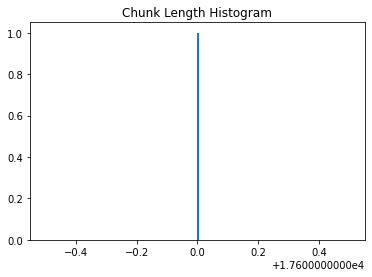

In [70]:
intervals = np.zeros(len(fullLC.gti))

for i, gti in enumerate(fullLC.gti):
    intervals[i] = gti[1] - gti[0]
plt.title("Chunk Length Histogram")
#histogram of chunk lengths
_ = plt.hist(intervals, 200)

In [71]:
print(intervals)

[17600.]


In [72]:
fullpds = stingray.Powerspectrum(fullLC, norm='frac')

In [73]:
fullsim = Simulator(dt=10,N=1760,mean=np.mean(fullLC.countrate))

In [74]:
%%time
#create random light curves, run a z^2

fulllimit= 100
fullsimZ = []
fullsimFreq= []
for i in range (fulllimit):
    sim_lc=sim.simulate(fullpds.power)
    event = EventList()
    event.simulate_times(sim_lc)
    simfrequency_z, simzstat = z_n_search(event.time, frequencies, nbin = 75, nharm = 2)
    fullsimZ.append(np.max(simzstat))
    fullsimFreq.append(simfrequency_z[np.argmax(simzstat)])

    

/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


ValueError: simulate_times can only work with positive-definite light curves

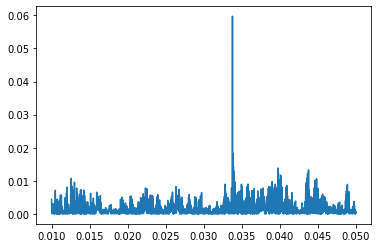

In [77]:
freqs = np.arange(10e-3, 50e-3, 1e-6)
ls = LombScargle(fullLC.time, fullLC.counts, dy = fullLC.counts_err, center_data = True, fit_mean = True)
plt.plot(freqs, ls.power(freqs))

In [78]:
ls.false_alarm_probability(np.max(ls.power(freqs)), method = 'bootstrap')

0.0030000000000000027

In [79]:
print(ls.false_alarm_probability(np.max(ls.power(freqs)), method = 'bootstrap'))
print(ls.false_alarm_probability(np.max(ls.power(freqs)), method = 'bootstrap'))
print(ls.false_alarm_probability(np.max(ls.power(freqs)), method = 'bootstrap'))
print(ls.false_alarm_probability(np.max(ls.power(freqs)), method = 'bootstrap'))

0.0010000000000000009
0.007000000000000006
0.0040000000000000036
0.0030000000000000027


In [80]:
print(ls.false_alarm_probability(np.max(ls.power(freqs))*1.001, method = 'bootstrap'))
print(ls.false_alarm_probability(np.max(ls.power(freqs)), method = 'bootstrap'))
print(ls.false_alarm_probability(np.max(ls.power(freqs))*0.999, method = 'bootstrap'))

0.0020000000000000018
0.0020000000000000018
0.0010000000000000009


In [81]:
ls.false_alarm_probability(np.max(ls.power(freqs)))

1.254960704584089e-19

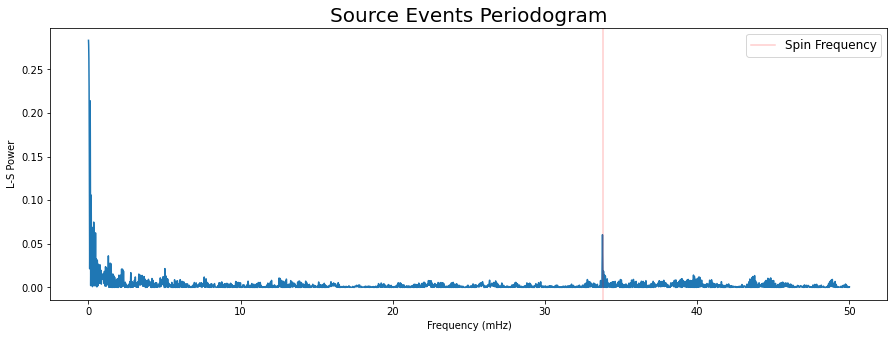

In [82]:

    fullfrequency_ls= np.arange(1e-5,50e-3, 1e-6)
    full_ls = LombScargle(src_lc.time, src_lc.counts, dy=src_lc.counts_err, center_data=True, fit_mean=True)
    level_tholds = full_ls.false_alarm_level(prob_tholds, method='baluev')
    fullpower_ls = full_ls.power(fullfrequency_ls)
    
    plt.figure(figsize=(15, 5))
    plt.plot(1000*fullfrequency_ls, fullpower_ls)

    plt.title('Source Events Periodogram', fontsize='20')
    plt.xlabel('Frequency (mHz)')
    plt.axvline(1000*spin_freq,color='r', alpha=.2,label='Spin Frequency')
    plt.legend(loc='upper right', fontsize='large')
    _=plt.ylabel('L-S Power')

In [83]:
#mask is a boolean array that is false outside the frequency range
mask =  (energy >= 30e-3) & (energy <= 40e-3)
#zoomedFullPower = np.extract(np.where(fullfrequency_ls == mask), fullpower_ls)

In [84]:
power = fullpower_ls
freq_mask =  (fullfrequency_ls >= 30e-3) & (fullfrequency_ls <= 40e-3)
zoomed_full_power = power[freq_mask]

In [85]:
zoomed_full_power

array([0.00148726, 0.00153232, 0.00157604, ..., 0.00692629, 0.00667646,
       0.00639099])

In [86]:
fullPeakPower =np.max(zoomed_full_power)

In [87]:
fullPeakFrequency = fullfrequency_ls[np.where(fullpower_ls == fullPeakPower)]

In [88]:
print(fullPeakFrequency)
print(fullPeakPower)

[0.033776]
0.06047874887238996


In [89]:
fullfrequency_ls
fullpower_ls

array([2.83372675e-01, 2.83061970e-01, 2.82718891e-01, ...,
       2.11967516e-04, 5.90319183e-04, 5.90082806e-04])

In [90]:
fullfrequency_ls[10000:]

array([0.01001 , 0.010011, 0.010012, ..., 0.049997, 0.049998, 0.049999])

In [91]:
np.max(fullpower_ls[10000:])

0.06047874887238996

In [92]:
full_ls.false_alarm_probability(np.max(fullpower_ls[10000:]),method='bootstrap')

0.006000000000000005

In [93]:
fullfrequency_ls[10000:]

array([0.01001 , 0.010011, 0.010012, ..., 0.049997, 0.049998, 0.049999])

In [94]:
full_ls.false_alarm_probability(fullPeakPower,method='bootstrap')

0.0020000000000000018

In [95]:
full_ls.false_alarm_probability(np.max(fullpower_ls),method='bootstrap')

0.0

In [96]:
full_ls.false_alarm_probability(fullPeakPower,method='davies')

6.209450866253756e-20

In [97]:
full_ls.false_alarm_probability(fullPeakPower)

6.209450866253756e-20

In [98]:
full_ls.false_alarm_probability(fullPeakPower,method='baluev')

6.209450866253756e-20

In [99]:
full_ls.false_alarm_probability(fullPeakPower,method='naive')

6.948924387476376e-21

## Lomb Scargle Bootstrp

In [100]:
fullsim = Simulator(dt=10,N=1760,mean=np.mean(fullLC.countrate), rms = .1)

In [101]:
%%time
#create random light curves, run a z^2

fulllimit= 100
fullsimLombScargle = []
fullsimFreq= []
for i in range (fulllimit):
    sim_lc=fullsim.simulate(fullpds.power)
    event = EventList()
    event.simulate_times(sim_lc) 
    simfrequency_ls= np.arange(20e-3,40e-3, 1e-6)
    simls = LombScargle(sim_lc.time, sim_lc.counts, dy=sim_lc.counts_err, center_data=True, fit_mean=True)
    simpower_ls = simls.power(simfrequency_ls)
    fullsimLombScargle.append(np.max(simpower_ls))
    fullsimFreq.append(simfrequency_ls[np.argmax(simpower_ls)])

/Users/ciro/.pyenv/versions/3.9.7/lib/python3.9/site-packages/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


CPU times: user 750 ms, sys: 206 ms, total: 955 ms
Wall time: 961 ms


In [102]:
#np.mean(fullsimFreq)
len(fullsimLombScargle)

100

In [103]:
# Find confidence interval

pct = .68 # Percent confidence (1 sigma)

full_sim_deltas = abs(fullsimFreq - full_spin) # Distance from best_freq

fullrounded_pct = int(pct*len(full_sim_deltas))

fullScargleError = max(nsmallest(fullrounded_pct, full_sim_deltas))

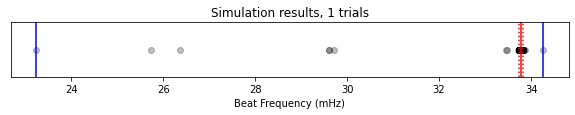

In [104]:
plt.figure(figsize=(10,1))

plt.scatter([1000*f for f in fullsimFreq], np.zeros_like(fullsimFreq), color='black', alpha=0.25)
plt.axvline(1000*my_spin, color='r')
plt.axvline(1000*(np.max(fullsimFreq)), color='blue', linestyle='-')
plt.axvline(1000*(np.min(fullsimFreq)), color='blue', linestyle='-')
plt.axvline(1000*(full_spin-fullScargleError), color='r', linestyle=':')
plt.axvline(1000*(full_spin+fullScargleError), color='r', linestyle=':')
plt.yticks([])

#plt.xlim(33.4, 34.2)

plt.title('Simulation results, '+str(limit)+' trials')
plt.xlabel('Beat Frequency (mHz)')

plt.show()

In [105]:
level_tholds = simls.false_alarm_level(prob_tholds, method='baluev')

(33.5, 34.0)

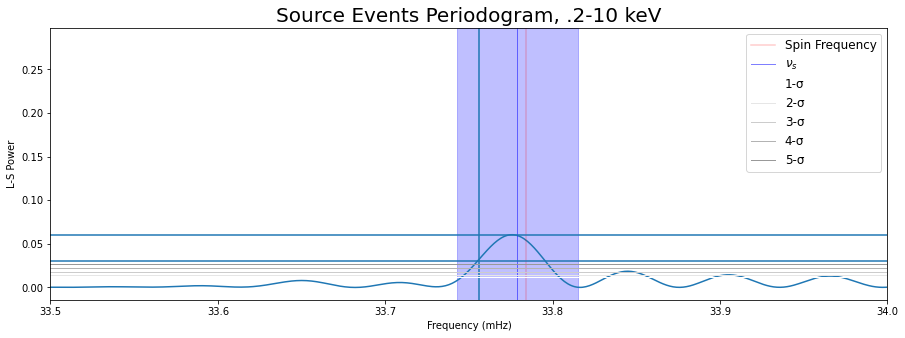

In [106]:
plt.figure(figsize=(15, 5))
plt.plot(1000*fullfrequency_ls[:-15000], fullpower_ls[:-15000])

plt.title('Source Events Periodogram, .2-10 keV', fontsize='20')
plt.xlabel('Frequency (mHz)')
plt.axvline(1000*spin_freq,color='r', alpha=.2,label='Spin Frequency')
plt.axvspan(1000*(full_spin - fullScargleError), 1000*(full_spin + fullScargleError), alpha=0.25, color='blue')
plt.axvline(1000*full_spin, lw=1, alpha=0.5, color='blue', label=r'$\nu_{s}$')

plt.axhline(.06)
plt.axhline(.03)
plt.axvline(33.756)

for i in range(len(level_tholds)):
    plt.axhline(level_tholds[i], lw=1, alpha=1, color=(1 - i*.1, 1 - i*.1, 1 - i*.1), label=str(i+1)+'-\u03c3')

plt.legend(loc='upper right', fontsize='large')
_=plt.ylabel('L-S Power')
plt.xlim(33.5, 34)


In [107]:
fullspin = fullfrequency_ls[np.argmax(fullsimLombScargle)]

In [108]:
print('Spin estimate ('+str(100*pct)+' confidence) is', round(1000*full_spin, 8), '\u00b1 %f mHz' %(1000*fullScargleError))

Spin estimate (68.0 confidence) is 33.779 ± 0.036000 mHz


In [109]:
periodError=(1/full_spin)-(1/(full_spin+fullScargleError))

In [110]:
print('Spin estimate ('+str(100*pct)+' confidence) is', round(1/(full_spin), 8), '\u00b1 %f s' %(periodError))

Spin estimate (68.0 confidence) is 29.60419195 ± 0.031517 s


In [111]:
np.where(fullpower_ls==.3)

(array([], dtype=int64),)

## Z^2 for .3-2 band

In [113]:
soft_frequency_z, soft_zstat = z_n_search(softEV.time, frequencies, nbin = 75, nharm = 2)
soft_z_detlev = z2_n_detection_level(n = 2, epsilon = sig5, ntrial = len(frequencies))

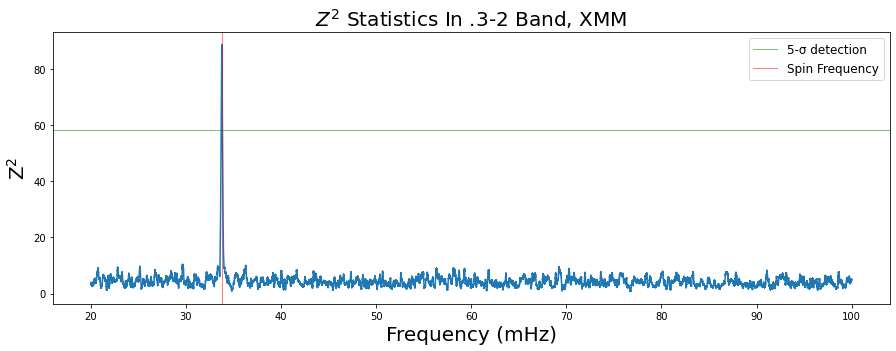

In [114]:
plt.figure(figsize=(15, 5))
plt.plot(1000*soft_frequency_z, soft_zstat)
plt.axhline(soft_z_detlev, lw=1, alpha=0.5, color='green', label='5-\u03c3 detection')
plt.axvline(spin_freq*1000, lw =1, alpha = .5,color='r', label='Spin Frequency')

plt.title(r'$Z^2$ Statistics In .3-2 Band, XMM', fontsize='20')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Frequency (mHz)', fontsize=20)
_=plt.ylabel('Z$^2$', fontsize=20)

In [117]:
softpds = stingray.Powerspectrum(softLC, norm='frac')

## Z^2 for 2-10 Band

In [ ]:
hard_frequency_z, hard_zstat = z_n_search(hardEV.time, frequencies, nbin = 75, nharm = 2)
hard_z_detlev = z2_n_detection_level(n = 2, epsilon = sig5, ntrial = len(frequencies))

In [ ]:
hard_frequency_z[np.argmax(hard_zstat)]

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(1000*hard_frequency_z, hard_zstat)
plt.axhline(hard_z_detlev, lw=1, alpha=0.5, color='green', label='5-\u03c3 detection')
plt.axvline(spin_freq*1000, lw =1, alpha = .5,color='r', label='Spin Frequency')

plt.title(r'$Z^2$ Statistics In 2-10 Band, XMM', fontsize='20')
plt.legend(loc='upper right', fontsize='large')
plt.xlabel('Frequency (mHz)', fontsize=20)
_=plt.ylabel('Z$^2$', fontsize=20)

In [ ]:
intervals = np.zeros(len(hardLC.gti))

for i, gti in enumerate(hardLC.gti):
    intervals[i] = gti[1] - gti[0]
plt.title("Chunk Length Histogram")
#histogram of chunk lengths
_ = plt.hist(intervals, 200)
print(intervals)

In [ ]:
sig1 = 1 - .6827 # Probability for 1-sigma detection
sig2 = 1 - .9545 # Probability for 2-sigma detection
sig3 = 1 - .9973 # Probability for 3-sigma detection
sig4 = 1 - .999937 # Probability for 4-sigma detection
sig5 = 1 - .9999994 # Probability for 5-sigma detection

prob_tholds = [sig1, sig2, sig3, sig4, sig5] # Probability thresholds to calculate FAP levels

# Pulse Profiles

In [ ]:
frequency_ef, efstat = epoch_folding_search(softEV.time, frequencies, nbin=20, gti=softEV.gti, expocorr=False)

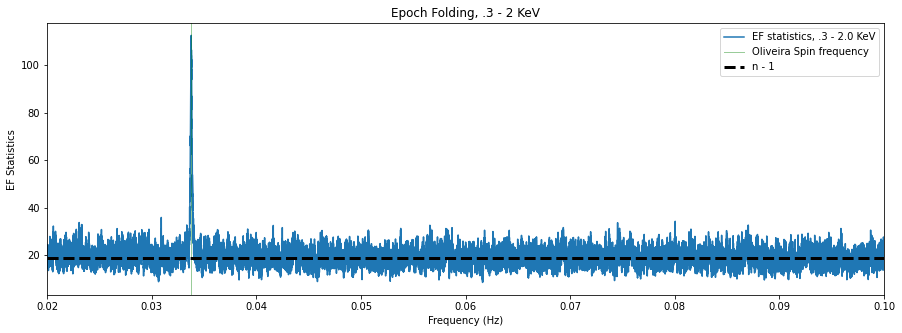

In [124]:
# Look at a range of pulsation frequencies to see "lay of the land"

#df_min = 1/gti_len_raw
#oversampling=20
#df = df_min / oversampling
#frequencies = np.arange(beat_freq - 1000 * df, beat_freq + 1000 * df, df)


# Note: for some reason the exposure correction is returning errors when we search around the orbital frequency.

# ---- PLOTTING --------
plt.figure(figsize=(15, 5))
plt.plot(frequency_ef, efstat, label='EF statistics, .3 - 2.0 KeV')
plt.axvline(spin_freq, lw=1, alpha=0.4, color='g', label='Oliveira Spin frequency')
plt.axhline(20 - 1, ls='--', lw=3, color='k', label='n - 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.title('Epoch Folding, .3 - 2 KeV')
plt.xlim(0.02,.1)
_ = plt.legend()

In [125]:
phase, folded_counts, folded_err = fold_events(softEV.time, spin_freq, nbin = 30)

In [132]:
hphase, hfolded_counts, hfolded_err = fold_events(hardEV.time, spin_freq, nbin = 30)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

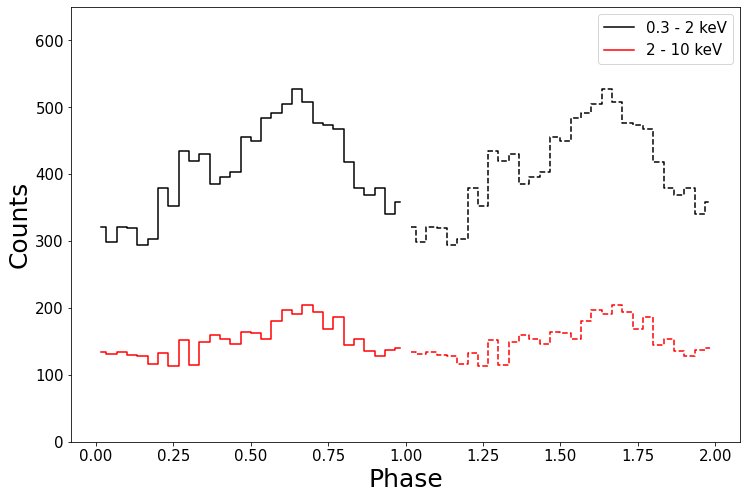

In [133]:
plt.figure(figsize=(12, 8))
plt.plot(phase, folded_counts, 'k', drawstyle = 'steps-mid', label = "0.3 - 2 keV")
plt.plot(phase+1, folded_counts, '--k', drawstyle = 'steps-mid')

plt.plot(hphase, hfolded_counts, drawstyle = 'steps-mid', color = "r", label = "2 - 10 keV")
plt.plot(hphase+1, hfolded_counts, '--', drawstyle = "steps-mid", color = "r")
plt.xlabel('Phase', fontsize = 25)
plt.ylabel('Counts', fontsize = 25)
plt.legend(loc='upper right', fontsize='15')
plt.ylim(0,650)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#plt.savefig('orbit_folded_lc.png')

In [134]:
hfrequency_ef, hefstat = epoch_folding_search(hardEV.time, frequencies, nbin=20, gti=hardEV.gti, expocorr=False)

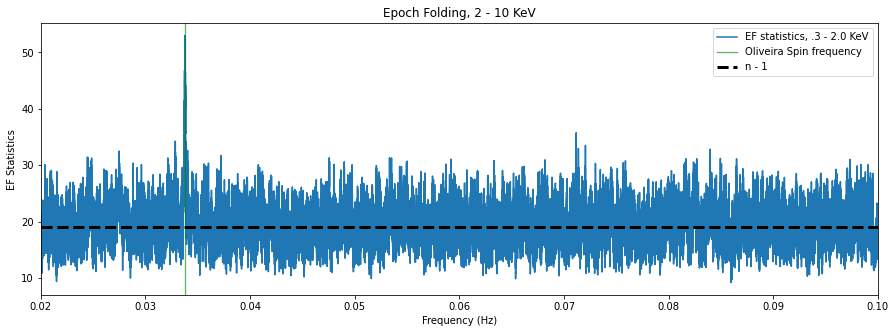

In [135]:
# Look at a range of pulsation frequencies to see "lay of the land"

#df_min = 1/gti_len_raw
#oversampling=20
#df = df_min / oversampling
#frequencies = np.arange(beat_freq - 1000 * df, beat_freq + 1000 * df, df)


# Note: for some reason the exposure correction is returning errors when we search around the orbital frequency.

# ---- PLOTTING --------
plt.figure(figsize=(15, 5))
plt.plot(hfrequency_ef, hefstat, label='EF statistics, .3 - 2.0 KeV')
plt.axvline(spin_freq, lw=1.3, alpha=0.6, color='g', label='Oliveira Spin frequency')
plt.axhline(20 - 1, ls='--', lw=3, color='k', label='n - 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.title('Epoch Folding, 2 - 10 KeV')
plt.xlim(0.02,.1)
_ = plt.legend()

Text(0, 0.5, 'Counts')

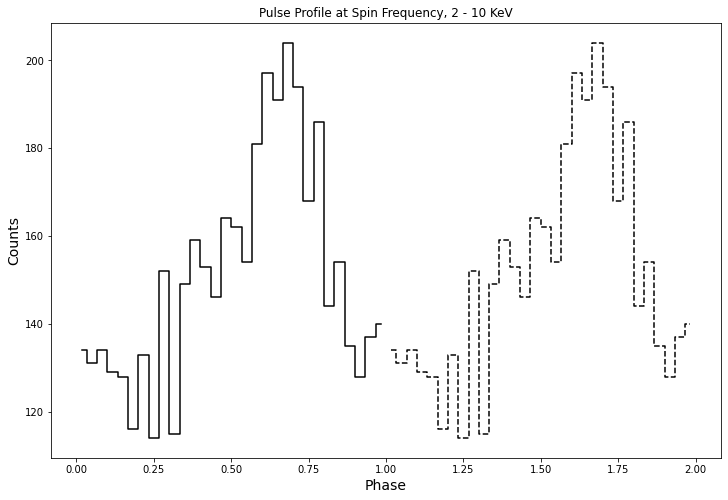

In [136]:
plt.figure(figsize=(12, 8))
plt.plot(hphase, hfolded_counts, 'k', drawstyle = 'steps-mid')
plt.plot(hphase+1, hfolded_counts, '--k', drawstyle = 'steps-mid')
plt.title("Pulse Profile at Spin Frequency, 2 - 10 KeV")

plt.xlabel('Phase', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)



In [ ]:
softP = z2_n_probability(np.max(soft_zstat), n=2, ntrial=len(frequencies), n_summed_spectra=1)

In [ ]:
hardP

In [ ]:
softP

In [ ]:
cand_freqs_z, cand_stat_z = search_best_peaks(soft_frequency_z, soft_zstat, soft_z_detlev)
hcand_freqs_z, hcand_stat_z = search_best_peaks(hard_frequency_z, hard_zstat, hard_z_detlev)


In [ ]:
fg=fit_gaussian(soft_frequency_z, zstat-(nbin-1),amplitude=max(efstat-(nbin-1)),
                mean=cand_freqs_ef[0], stddev=1/(np.pi*obs_length))